# 01_Preprocessing

 > Last Update: 06/13/2020 <br>
 Author: [Yalim Demirkesen](https://www.linkedin.com/in/yalimdemirkesen/)
 
 **Description**<br>
 This notebook is created for preprocessing. The input of this file is the campaign level dataset from FB Ads Manager. The content is completely altered and doesn't resemble any real data. Still, the project provides a very detailed approach on how to predict the conversions from a Facebook campaign and how the given ecommerce budget can be optimized to generate most conversions with spending as less as possible.
 

 
 

In [1]:
# necessary libraries:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from itertools import product
from datetime import date, timedelta
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

## Preparing the Data

In [2]:
fb = pd.read_csv("./data/campaign/fb_campaign.csv")

In [3]:
fb.columns

Index(['day', 'time_of_day', 'amount_spent_usd', 'location', 'industry',
       'conversion'],
      dtype='object')

In [4]:
print("There are {} rows in the dataset.".format(fb.shape[0]))

There are 140725 rows in the dataset.


In [5]:
# sort according to the day
fb = fb.sort_values(by=['day','time_of_day'])

In [6]:
fb.reset_index(drop=True,inplace=True)

In [7]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140725 entries, 0 to 140724
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   day               140725 non-null  object 
 1   time_of_day       140725 non-null  int64  
 2   amount_spent_usd  140725 non-null  float64
 3   location          140725 non-null  object 
 4   industry          140725 non-null  object 
 5   conversion        140725 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 6.4+ MB


In [8]:
print("The records start from {} and goes up to {}.".format(min(fb['day']),max(fb['day'])))

The records start from 2018-01-01 and goes up to 2019-09-30.


In [9]:
# convert the day column to datetime
fb['day'] = pd.to_datetime(fb['day'])

In [10]:
# create the day_of_week column which is the numeric version of days of the week:
fb['day_of_week']=fb['day'].dt.dayofweek

In [11]:
# convert the numeric values into strings:
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
fb['day_of_week'] = fb['day_of_week'].apply(lambda x: days[x])

In [12]:
# creating year, month and week values from the date
fb['year'] = fb['day'].dt.year
fb['month'] = fb['day'].dt.month
fb['week_num'] = fb['day'].dt.week

In [13]:
fb.head()

,day,time_of_day,amount_spent_usd,location,industry,conversion,day_of_week,year,month,week_num
0,2018-01-01,0,1.014516,ZA,SSF,0.0,Mon,2018,1,1
1,2018-01-01,0,3.218980,MX,OR,0.0,Mon,2018,1,1
2,2018-01-01,0,0.751900,ZA,OR,0.0,Mon,2018,1,1
3,2018-01-01,0,0.912500,FR,OR,0.0,Mon,2018,1,1
4,2018-01-01,0,20.898717,US,SSF,0.0,Mon,2018,1,1


In [14]:
fb.conversion.apply(lambda x: '0 conversions' if x==0 else 'more than 0 conversions').value_counts(normalize=True)

0 conversions              0.769387
more than 0 conversions    0.230613
Name: conversion, dtype: float64

In [15]:
# budget spent on campaigns that resulted in 0 conversions
a=fb[fb['conversion']==0]['amount_spent_usd'].sum()

# budget spent on campaigns that resulted in more than 0 conversions
b=fb[fb['conversion']!=0]['amount_spent_usd'].sum()

print("{}% of the e-commerce budget is completely wasted on campaigns that resulted in 0 conversions!!!".format(int(round(a/(a+b),2)*100)))

46% of the e-commerce budget is completely wasted on campaigns that resulted in 0 conversions!!!


The first step in the project is to predict the level of conversion. The best way is to convert the problem into a classification problem. This is so because:
1. The data is highly unbalanced. We have much more 0 conversions than any other. (77% is 0 conversions and 23% is more than 0 conversions) Higher the level of conversion gets, less frequent the number of observations get.
2. The main goal of the project is to detect when the money is absolutely wasted. In other words we want to predict the campaigns that will result in 0 conversions. The reason is that **46% of the e-commerce budget is completely wasted on campaigns that resulted in 0 conversions**!!!

It is now clear that classification problem is a right approach, let's focus on binning!

In [16]:
fb.conversion.value_counts(normalize=True)

0.0     0.769387
1.0     0.134944
2.0     0.050233
3.0     0.020146
4.0     0.010588
5.0     0.005521
6.0     0.003205
7.0     0.001983
8.0     0.001300
9.0     0.000945
10.0    0.000554
11.0    0.000348
12.0    0.000291
13.0    0.000178
14.0    0.000128
15.0    0.000092
16.0    0.000043
17.0    0.000036
22.0    0.000014
31.0    0.000014
19.0    0.000014
20.0    0.000007
26.0    0.000007
29.0    0.000007
18.0    0.000007
24.0    0.000007
Name: conversion, dtype: float64

In [17]:
def conversion_categ(df):
    if (df.conversion == 0):
        return "0 conversions"
    elif ((df.conversion>=1) & (df.conversion<=2)): 
        return "btw 1 and 2 conversions"
    elif ((df.conversion>=3) & (df.conversion<=5)): 
        return "btw 3 and 5 conversions"
    else:
        return 'more than 5 conversions'          

In [18]:
# create a labels column which will be the target variable:
fb['labels']=fb.apply(conversion_categ,axis=1)

In [19]:
fb.labels.value_counts(normalize=True)

0 conversions              0.769387
btw 1 and 2 conversions    0.185177
btw 3 and 5 conversions    0.036255
more than 5 conversions    0.009181
Name: labels, dtype: float64

Still I am not satisfied with this distribution. The reason is 77% is in the first class, 18% is in the second. That leaves only 5% for the remaining groups. That's why I will bin the time of the days into part of the days. 
- The hours between 0 and 6 will be labelled as `night`.
- The hours between 6 and 12 will be labelled as `morning`.
- The hours between 12 and 18 will be labelled as `afternoon`.
- The hours between 18 and 0 will be labelled as `evening`.

But before I do that, I will check whether the time of the day is a strong predictor on conversions. If yes there will be differences between hours. If not, we can simply combine them.

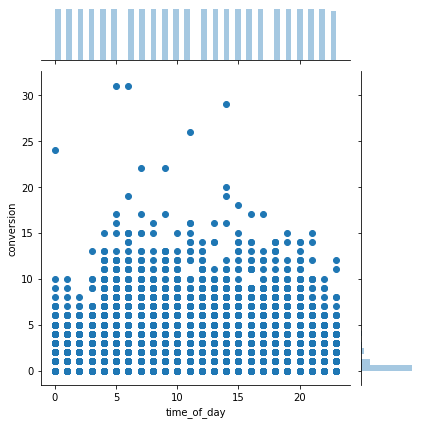

In [20]:
sns.jointplot(x="time_of_day", y="conversion", data=fb);

There are differences but very small and neglectable. That means I can go ahead and combine the hours:

In [21]:
fb['part_of_day'] = fb['time_of_day'].apply(lambda x: 'night' if (x>= 0 and x<=5) else (
                                            'morning' if (x>=6 and x<=11) else (
                                                'afternoon' if (x>=12 and x<=18) else
                                                    'evening')))

In [22]:
fb.groupby('part_of_day').agg({'conversion':'sum'})

,conversion
part_of_day,
afternoon,18877.0
evening,9809.0
morning,19322.0
night,13815.0


In [23]:
# since I won't use time, I will remove it.
# labels also needs to be removed since new bins will be introduced.
fb.drop(columns=['time_of_day','labels','day_of_week','year','month','week_num'],inplace=True)

In [24]:
fb_grouped = fb.groupby(['day','part_of_day','location','industry']).agg('sum').reset_index()

In [25]:
fb_grouped.head()

,day,part_of_day,location,industry,amount_spent_usd,conversion
0,2018-01-01,afternoon,DE,SSF,17.052800,1.0
1,2018-01-01,afternoon,ES,OR,23.137473,1.0
2,2018-01-01,afternoon,FR,OR,3.204700,0.0
3,2018-01-01,afternoon,FR,SSF,39.000829,0.0
4,2018-01-01,afternoon,IT,OR,11.831640,0.0


Let's repeat the work we have done since all the time related information is deleted as well as the conversion bins.

In [26]:
# create the day_of_week column which is the numeric version of days of the week:
fb_grouped['day_of_week']=fb_grouped['day'].dt.dayofweek

In [27]:
# convert the numeric values into strings:
fb_grouped['day_of_week'] = fb_grouped['day_of_week'].apply(lambda x: days[x])

In [28]:
# creating year, month and week values from the date
fb_grouped['year'] = fb_grouped['day'].dt.year
fb_grouped['month'] = fb_grouped['day'].dt.month
fb_grouped['week_num'] = fb_grouped['day'].dt.week

For the labels:

In [29]:
fb_grouped['conversion'].value_counts(normalize=True)[:10]

0.0     0.392491
1.0     0.192781
2.0     0.123760
3.0     0.074453
4.0     0.053755
5.0     0.034169
6.0     0.025316
7.0     0.016721
8.0     0.012872
9.0     0.010263
10.0    0.007954
Name: conversion, dtype: float64

Let's check the new distribution of the conversion bins:

In [30]:
# create a labels column which will be the target variable:
fb_grouped['labels']=fb_grouped.apply(conversion_categ,axis=1)

In [31]:
fb_grouped.labels.value_counts(normalize=True)

0 conversions              0.392491
btw 1 and 2 conversions    0.316541
btw 3 and 5 conversions    0.162376
more than 5 conversions    0.128592
Name: labels, dtype: float64

Success! This is a much better distribution when it comes to conversion bins.

In [32]:
fb_grouped.head()

,day,part_of_day,location,industry,amount_spent_usd,conversion,day_of_week,year,month,week_num,labels
0,2018-01-01,afternoon,DE,SSF,17.052800,1.0,Mon,2018,1,1,btw 1 and 2 conversions
1,2018-01-01,afternoon,ES,OR,23.137473,1.0,Mon,2018,1,1,btw 1 and 2 conversions
2,2018-01-01,afternoon,FR,OR,3.204700,0.0,Mon,2018,1,1,0 conversions
3,2018-01-01,afternoon,FR,SSF,39.000829,0.0,Mon,2018,1,1,0 conversions
4,2018-01-01,afternoon,IT,OR,11.831640,0.0,Mon,2018,1,1,0 conversions


Before starting the analysis, I will check the trend over time of cost per conversion:

In [33]:
fb_gr = pd.concat([fb_grouped['day'].dt.strftime("%Y-%m"),fb_grouped.iloc[:,1:]],axis=1)
fb_gr = fb_gr.groupby('day').agg({'amount_spent_usd': 'sum','conversion':'sum'}).reset_index()
fb_gr['cost_per_conv']=fb_gr['amount_spent_usd']/fb_gr['conversion']
fb_gr

,day,amount_spent_usd,conversion,cost_per_conv
0,2018-01,59631.3202,2858.0,20.864703
1,2018-02,59078.0897,2790.0,21.174943
2,2018-03,49191.7508,2046.0,24.042889
3,2018-04,55259.8028,2095.0,26.376994
4,2018-05,46875.5557,2251.0,20.824325
5,2018-06,49463.3984,2173.0,22.762724
6,2018-07,62393.2679,3230.0,19.316801
7,2018-08,56489.5389,2366.0,23.875545
8,2018-09,49183.9179,1589.0,30.952749
9,2018-10,52335.6053,2372.0,22.063915


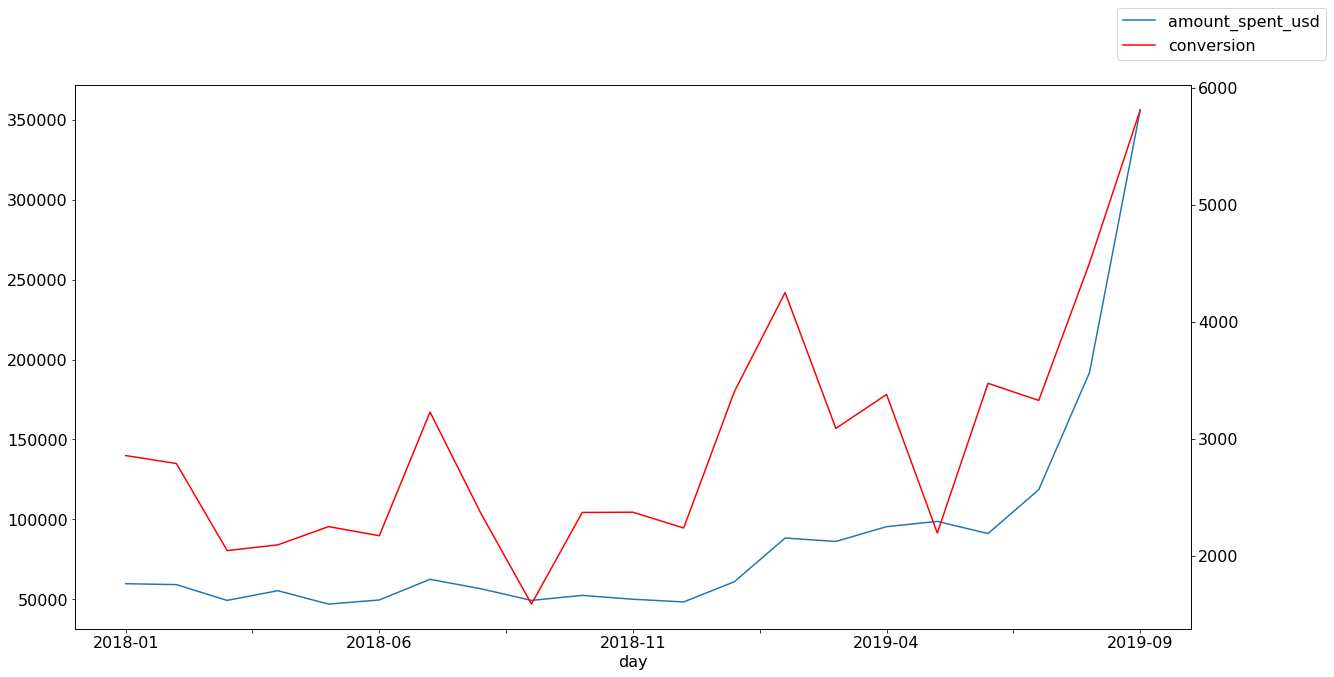

In [34]:
plt.rcParams.update({'font.size': 16})
ax = fb_gr.plot(x="day", y="amount_spent_usd", legend=False,figsize=(20,10))
ax2 = ax.twinx()
fb_gr.plot(x="day", y="conversion", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

This table is a great indication that the cost per conversion is increasing drastically.

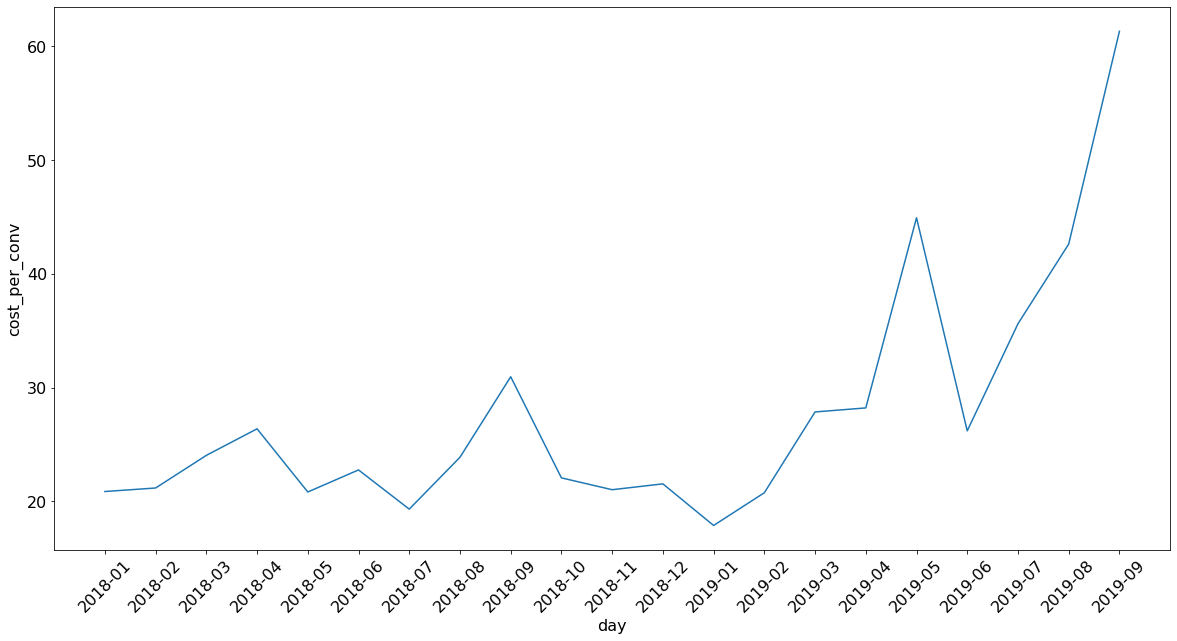

In [35]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 16})
plt.xticks(rotation=45)

ax = sns.lineplot(x="day", y="cost_per_conv", data=fb_gr)

Another known problem is the amount spent for time frames that generate 0 conversions:

In [36]:
fb0 = fb[fb['conversion']==0]
fb_gr0 = pd.concat([fb0['day'].dt.strftime("%Y-%m"),fb0.iloc[:,1:]],axis=1)
fb_gr0 = fb_gr0.groupby('day').agg({'amount_spent_usd': 'sum','conversion':'sum'}).reset_index()
fb_gr0

fb1 = fb[fb['conversion']!=0]
fb_gr1 = pd.concat([fb1['day'].dt.strftime("%Y-%m"),fb1.iloc[:,1:]],axis=1)
fb_gr1 = fb_gr1.groupby('day').agg({'amount_spent_usd': 'sum','conversion':'sum'}).reset_index()
fb_gr1

df_comp = pd.DataFrame(zip(fb_gr0['day'],fb_gr0['amount_spent_usd'],fb_gr1['amount_spent_usd']),columns=['month','0','+0'])
df_comp

,month,0,+0
0,2018-01,33423.349807,26207.970393
1,2018-02,35303.438499,23774.651201
2,2018-03,35006.644340,14185.106460
3,2018-04,34758.292159,20501.510641
4,2018-05,28498.251995,18377.303705
5,2018-06,20853.798122,28609.600278
6,2018-07,30723.595300,31669.672600
7,2018-08,30354.037592,26135.501308
8,2018-09,24771.969454,24411.948446
9,2018-10,21385.715858,30949.889442


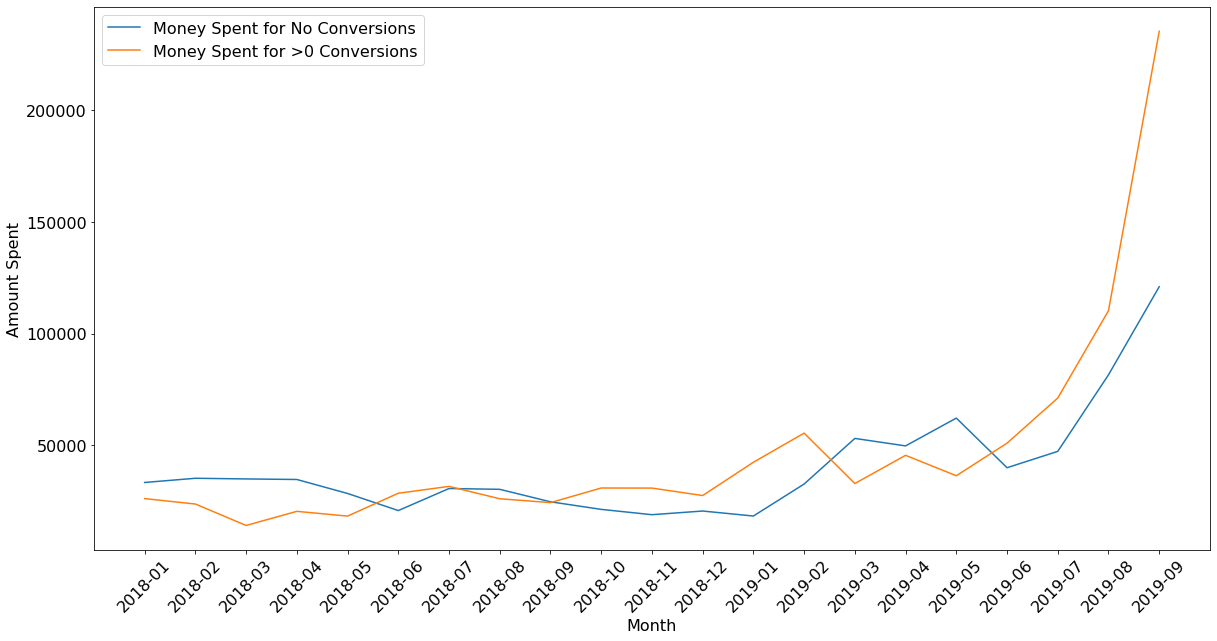

In [37]:
plt.figure(figsize=(20,10))

# Declaring the points for first line plot
X1 = df_comp['month'] 
Y1 = df_comp['0']
# plotting the first plot
plt.plot(X1, Y1, label = "Money Spent for No Conversions") 

# Declaring the points for first line plot
X2 = df_comp['month'] 
Y2 = df_comp['+0']
# plotting the first plot
plt.plot(X2, Y2, label = "Money Spent for >0 Conversions") 
  
# Labeling the X-axis 
plt.xlabel('Month') 

# Labeling the Y-axis 
plt.ylabel('Amount Spent') 
  
# Show a legend on the plot 
plt.legend() 

# rotate x tickets:
plt.xticks(rotation=45)
 
plt.show() 

From the above graph we can see that the amount spent on the campaigns with no return is drastically increasing and lately on September 2019 it was more than $100,000!!! 

*This is the amount of spent on a granularity of time of the day.*

In a truly optimized marketing campaign, the more you spent, more conversions you generate. There should be a linear relationship. It might even be exponential. If you spend one increment more, there might be more then one unit increase because the company's awareness also increases and you hit two birds with one stone. Let's check deeper to understand the relationship between the amount spent and conversions in my case.

First, I will check the distribution of the conversions. 

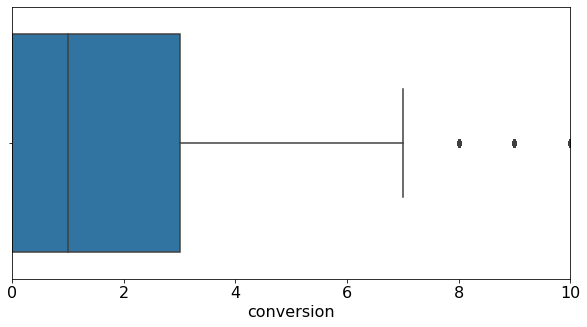

In [38]:
plt.figure(figsize=(10,5))
plt.xlim(0, 10)
sns.boxplot(x='conversion',data=fb_grouped)

Second, I will check the distribution of the amount spent. 

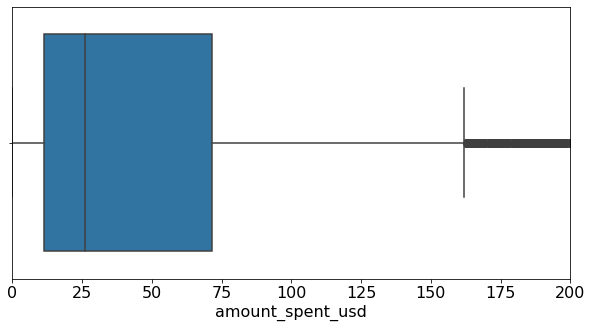

In [39]:
plt.figure(figsize=(10,5))
plt.xlim(0, 200)
sns.boxplot(x='amount_spent_usd',data=fb_grouped)

Below, I can see the relationship of the amount spend and conversion. At least it is comforting to see the positive relationship between conversions and amount spent.

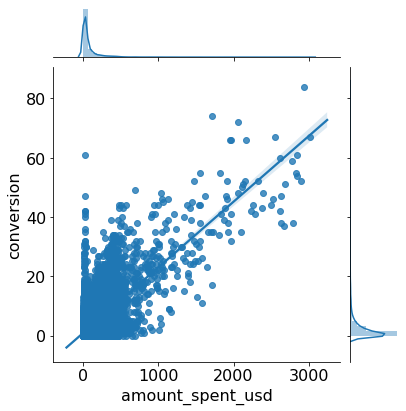

In [40]:
sns.jointplot(x="amount_spent_usd", y="conversion",data=fb_grouped,kind="reg");

Creating the dummy columns:

In [41]:
fb_grouped.head()

,day,part_of_day,location,industry,amount_spent_usd,conversion,day_of_week,year,month,week_num,labels
0,2018-01-01,afternoon,DE,SSF,17.052800,1.0,Mon,2018,1,1,btw 1 and 2 conversions
1,2018-01-01,afternoon,ES,OR,23.137473,1.0,Mon,2018,1,1,btw 1 and 2 conversions
2,2018-01-01,afternoon,FR,OR,3.204700,0.0,Mon,2018,1,1,0 conversions
3,2018-01-01,afternoon,FR,SSF,39.000829,0.0,Mon,2018,1,1,0 conversions
4,2018-01-01,afternoon,IT,OR,11.831640,0.0,Mon,2018,1,1,0 conversions


In [42]:
# since date is depicted in other columns, we can drop it:
fb_grouped = fb_grouped.drop(columns=['day'])

In [43]:
fb_final = pd.concat([fb_grouped,
                      pd.get_dummies(fb_grouped['part_of_day']),
                      pd.get_dummies(fb_grouped['location']),
                      pd.get_dummies(fb_grouped['industry']),
                      pd.get_dummies(fb_grouped['day_of_week']), 
                      pd.get_dummies(fb_grouped['year'])],axis=1)

fb_final = fb_final.drop(columns=['location','industry','day_of_week','year','conversion'])

In [44]:
fb_final=fb_final[['part_of_day',
 'amount_spent_usd',
 'month',
 'week_num',
 'DE',
 'ES',
 'FR',
 'IT',
 'MX',
 'UK',
 'US',
 'ZA',
 'OR',
 'SSF',
 'Fri',
 'Mon',
 'Sat',
 'Sun',
 'Thurs',
 'Tues',
 'Weds',
 2018,
 2019,
 'labels']]

In [45]:
fb_final = fb_final.rename(columns={2018:'2018',2019:'2019'})

In [46]:
fb_final.head()

,part_of_day,amount_spent_usd,month,week_num,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019,labels
0,afternoon,17.052800,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,btw 1 and 2 conversions
1,afternoon,23.137473,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,btw 1 and 2 conversions
2,afternoon,3.204700,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0 conversions
3,afternoon,39.000829,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0 conversions
4,afternoon,11.831640,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0 conversions


In [47]:
fb_final.to_csv('./data/fb.csv')

## Generating the Test Set

The goal of the project is to train a model that can predict what the outcome of the campaigns will be in terms of conversions. The result will be on of the classes determined earlier: 0 conversions, 1-2 conversions, 3-6 and +6 conversions. In this section, I will create a dataset with all of the combinations time, month, week_num, location, industry, day of the week and year. For the amount spent I will apply an incremental increase from a lower bound to an upper bound.

In [48]:
# first day of the prediction:
date1 = '2019-09-01'

In [49]:
date1 = datetime.strptime(date1, '%Y-%m-%d').date()

In [50]:
# last day of the prediction
date2 = '2019-09-30'

In [51]:
date2 = datetime.strptime(date2, '%Y-%m-%d').date()

In [52]:
print("The predictions will run from {} until {}!".format(date1,date2))

The predictions will run from 2019-09-01 until 2019-09-30!


In [53]:
# Create a list that gives all the dates between the initial and the last date.
d1 = date1  # start date
d2 = date2  # end date

delta = d2 - d1  # timedelta

dates = [] # empty list to store all the dates in between

for i in range(delta.days + 1):
    dates.append(d1 + timedelta(days=i))

dates

[datetime.date(2019, 9, 1),
 datetime.date(2019, 9, 2),
 datetime.date(2019, 9, 3),
 datetime.date(2019, 9, 4),
 datetime.date(2019, 9, 5),
 datetime.date(2019, 9, 6),
 datetime.date(2019, 9, 7),
 datetime.date(2019, 9, 8),
 datetime.date(2019, 9, 9),
 datetime.date(2019, 9, 10),
 datetime.date(2019, 9, 11),
 datetime.date(2019, 9, 12),
 datetime.date(2019, 9, 13),
 datetime.date(2019, 9, 14),
 datetime.date(2019, 9, 15),
 datetime.date(2019, 9, 16),
 datetime.date(2019, 9, 17),
 datetime.date(2019, 9, 18),
 datetime.date(2019, 9, 19),
 datetime.date(2019, 9, 20),
 datetime.date(2019, 9, 21),
 datetime.date(2019, 9, 22),
 datetime.date(2019, 9, 23),
 datetime.date(2019, 9, 24),
 datetime.date(2019, 9, 25),
 datetime.date(2019, 9, 26),
 datetime.date(2019, 9, 27),
 datetime.date(2019, 9, 28),
 datetime.date(2019, 9, 29),
 datetime.date(2019, 9, 30)]

In [54]:
fb_final.head()

,part_of_day,amount_spent_usd,month,week_num,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019,labels
0,afternoon,17.052800,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,btw 1 and 2 conversions
1,afternoon,23.137473,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,btw 1 and 2 conversions
2,afternoon,3.204700,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0 conversions
3,afternoon,39.000829,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0 conversions
4,afternoon,11.831640,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0 conversions


In [57]:
# all combinations for time of the day
part_of_day = fb_grouped.part_of_day.value_counts().index.tolist()

# country combinations
country = fb_grouped.location.value_counts().index.tolist()

# industry combinations
industry = fb_grouped.industry.value_counts().index.tolist()

In [64]:
# Creating the first version of the dataframe:
df_testset = pd.DataFrame(list(product(dates,part_of_day,country,industry)), 
                          columns = ['date','part_of_day','location','industry'])

In [65]:
# The date column is divided into year, month and week number.
df_testset['date'] = pd.to_datetime(df_testset['date'], errors = 'coerce')

df_testset['year'] = df_testset['date'].dt.year
df_testset['month'] = df_testset['date'].dt.month
df_testset['week_num'] = df_testset['date'].dt.week

df_testset['day_of_week']=df_testset['date'].dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df_testset['day_of_week'] = df_testset['day_of_week'].apply(lambda x: days[x])

In [66]:
df_testset = pd.concat([df_testset,
                        pd.get_dummies(df_testset['part_of_day']),
                        pd.get_dummies(df_testset['location']),
                        pd.get_dummies(df_testset['industry']),
                        pd.get_dummies(df_testset['day_of_week'])],axis=1)
df_testset.drop(columns=['date','part_of_day','location','industry','year','day_of_week'],inplace=True)
df_testset['2018'] = 0
df_testset['2019'] = 1
df_testset.head(10)

,month,week_num,afternoon,evening,morning,night,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019
0,9,35,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
1,9,35,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,9,35,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,9,35,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,9,35,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
5,9,35,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
6,9,35,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
7,9,35,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
8,9,35,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
9,9,35,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [67]:
# Dropping the duplicates and resetting the index of the dataframe:
df_testset = df_testset.drop_duplicates().reset_index(drop = True)

To verify that all the combinations are created, the length of the dataframe is calculated which turned out to be 1920. It is important to calculate the same number by multiplying the possibilities of each column. So let's multiply the amount of different:
- part of day: 4
- location: 8
- industry: 2
- days: 30
$$ 4*8*2*30=1920 $$

This is the proof that each possible combination is created!

In [68]:
4*8*2*30

1920

In [69]:
len(df_testset)

1920

**Adding the Incremental Increase for Budget:**

Here there are three points to consider:
1. lower bound
2. upper bound
3. incremental increase

Best way to decide this is to understand the distribution of the amount spent:

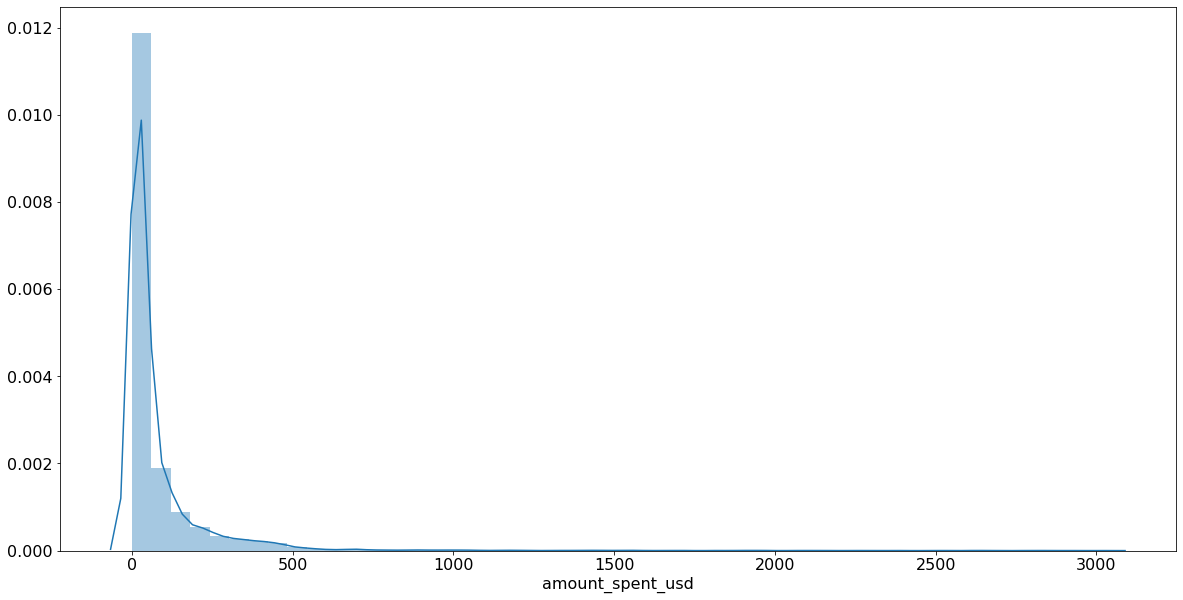

In [70]:
plt.figure(figsize=(20,10))
ax = sns.distplot(fb_final['amount_spent_usd'])

In [71]:
fb_final['amount_spent_usd'].describe()

count    23384.000000
mean        78.051471
std        166.001596
min          0.000000
25%         11.366100
50%         26.208126
75%         71.651938
max       3022.392630
Name: amount_spent_usd, dtype: float64

In [76]:
fb_final.quantile(.90)['amount_spent_usd']

202.74900921256713

In [75]:
fb_final.quantile(.95)['amount_spent_usd']

331.87515499999984

In [77]:
fb_final.quantile(.99)['amount_spent_usd']

687.6845056290529

From the above information, I decide to pick the:
- lower bound as `0`
- upper bound as `350` which is more than the 95th quartile
- increment as `2` so there will be 175 increments for each combination

In [78]:
# Since there are 175 increments, we need to concatenate the already existing dataframe 175 times with itself.
df_increment = pd.concat([df_testset]*len(pd.Series(range(0,351,2)))).reset_index(drop=True)

In [80]:
inc = list(range(0,351,2))

some_lst = []
for i in range(len(inc)):
    some_lst = some_lst + ([inc[i]]*len(df_testset))

To check whether all are created correctly, I need to multiply the length of the range from 0 to 350 having increments of 2 with the length of the prior dataset. That length needs to be equal to the new dataframe, which is the case as it can be seen below:

In [83]:
len(df_increment)

337920

In [84]:
len(df_testset)*len(range(0,351,2))

337920

In [85]:
len(some_lst)

337920

In [86]:
df_increment['amount_spend_usd'] = pd.Series(some_lst)

In [87]:
df_increment.reset_index(drop=True, inplace=True)

Sanity check:

In [88]:
df_increment.head()

,month,week_num,afternoon,evening,morning,night,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019,amount_spend_usd
0,9,35,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
1,9,35,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
2,9,35,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,9,35,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,9,35,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [95]:
# Checking a certain combination and seeing whether the incremental increase in 'amount_spent_(usd)' works:
df_increment[(df_increment['month']==9)&\
             (df_increment['week_num']==35)&\
             (df_increment['afternoon']==1)&\
             (df_increment['DE']==1)&\
             (df_increment['OR']==1)&\
             (df_increment['Sun']==1)
            ]

,month,week_num,afternoon,evening,morning,night,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019,amount_spend_usd
10,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1930,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,2
3850,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,4
5770,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,6
7690,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,8
9610,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,10
11530,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12
13450,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,14
15370,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,16
17290,9,35,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,18


What I have done above was to check for one combination of date, part of the day, location, industry and day of the week. I expected to have amount spend column having increments of 2 from 0 to 350 which was the case. So preprocessing is completed! 

In [96]:
df_increment.to_csv('./data/testdata_sep.csv')